<a href="https://colab.research.google.com/github/Rishi210904/Project-1-of-LLM/blob/main/project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install datasets
!pip install tiktoken
!pip install safetensors
!pip install llms-from-scratch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 22.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [9]:
#importing important libraries
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import pandas as pd
import tiktoken
from llms_from_scratch.ch04 import GPTModel

In [13]:
from datasets import load_dataset
ds_full = load_dataset("fancyzhx/ag_news")

In [14]:
from datasets import load_dataset

# Load the full dataset
ds_full= load_dataset("fancyzhx/ag_news", split="train")

# Select the first 30,000 rows
ds = ds_full.select(range(50000))

# We are verifying that the first 30k rows are taken as a new dataset
print(ds)

Dataset({
    features: ['text', 'label'],
    num_rows: 50000
})


In [15]:
# first split:
split_1 = ds.train_test_split(test_size=0.4, stratify_by_column="label", seed=123)
train_ds = split_1["train"]
temp_ds = split_1["test"]

# Second split: Val vs Test (from temp_ds)
split_2 = temp_ds.train_test_split(test_size=0.5, stratify_by_column="label", seed=123)
val_ds = split_2["train"]
test_ds = split_2["test"]

In [16]:
train_df = train_ds.to_pandas()
val_df = val_ds.to_pandas()
test_df = test_ds.to_pandas()


In [17]:
train_df.head()

,text,label
0,Insurance Companies Try Out Auto Black Boxes B...,3
1,Israel Talks Tough to Arafat Silvan Shalom cal...,0
2,Sony leans on discount retailers Japanese elec...,2
3,GE warned over perks for ex-chief US industria...,2
4,Truckers call off week-long strike Joint pane...,2


In [21]:
train_df.to_csv("train.csv", index=None)
val_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

class NewsData(Dataset):
    def __init__(self, csv_file, tokenizer, max_length = None, pad_token_id = 50256):
        self.data = pd.read_csv(csv_file)

        # tokenizes the text in the csv file and self.encoded_texts stores the list of encoded sequences.
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["text"]
        ]

        #if max_length is not given, compute it as the length of the longest tokenized sequence.
        if max_length is None:
            self.max_length = self._longest_encoded_length()

        else:
            self.max_length = max_length
            # truncate sequences if they are longer than max_length
            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]

        #pad all sequences to the same length (self.max_length) using the pad_token_id.
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

    #gets the padded token IDs and label for the index-th example.
    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        ) #returns the encoded sequence and label as PyTorch tensors.

    def __len__(self):
        return len(self.data)

    #computes and returns the length of the longest sequence in self.encoded_texts.
    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length

[50256]


In [23]:
train_dataset = NewsData(
    csv_file = "train.csv",
    max_length = None,
    tokenizer = tokenizer
)

val_dataset = NewsData(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

test_dataset = NewsData(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
num_workers = 2
batch_size = 16 #each batch will contain 16 samples
torch.manual_seed(123)

'''
loads data from train_dataset.
shuffle=True: randomly shuffles the data each epoch — important for training to reduce bias.
drop_last=True: drops the last batch if it has fewer than 8 samples — useful for ensuring consistent batch sizes.
'''
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset = val_dataset,
    batch_size = batch_size,
    num_workers = num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset = test_dataset,
    batch_size = batch_size,
    num_workers = num_workers,
    drop_last=False,
)
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

1875 training batches
625 validation batches
625 test batches


In [24]:
from importlib.metadata import version

pkgs = ["numpy", "torch", "safetensors"]
for p in pkgs:
    print(f"{p} version: {version(p)}")

numpy version: 2.0.2
torch version: 2.6.0+cu124
safetensors version: 0.5.3


In [25]:
BASE_CONFIG = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "drop_rate": 0.0,       # Dropout rate
    "qkv_bias": True        # Query-key-value bias
}

#this dictionary defines different GPT-2 model variants
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}


CHOOSE_MODEL = "gpt2-medium (355M)" #we choose which model to use.
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])
#above, we add the model-specific parameters (like emb_dim, n_layers, n_heads) to the base config, resulting in one complete config dictionary.

'''
{
    "vocab_size": 50257,
    "context_length": 1024,
    "drop_rate": 0.0,
    "qkv_bias": True,
    "emb_dim": 768,
    "n_layers": 12,
    "n_heads": 12
}
after adding the model specific parameters.
'''

'\n{\n    "vocab_size": 50257,\n    "context_length": 1024,\n    "drop_rate": 0.0,\n    "qkv_bias": True,\n    "emb_dim": 768,\n    "n_layers": 12,\n    "n_heads": 12\n}\nafter adding the model specific parameters.\n'

In [26]:
#downloads and loads a pretrained GPT-2 model checkpoint from Hugging Face using safetensors.
import os
import urllib.request #for downloading files via HTTP.
from safetensors.torch import load_file #from the safetensors package—efficient and safe model weight loading


#maps the human-readable CHOOSE_MODEL name to the directory used on Hugging Face.
URL_DIR = {
  "gpt2-small (124M)": "gpt2",
  "gpt2-medium (355M)": "gpt2-medium",
  "gpt2-large (774M)": "gpt2-large",
  "gpt2-xl (1558M)": "gpt2-xl"
}

#the Hugging Face URL to the safetensors file for the selected model.
url = f"https://huggingface.co/openai-community/{URL_DIR[CHOOSE_MODEL]}/resolve/main/model.safetensors"
#output_file: local filename for saving the file (e.g., model-gpt2.safetensors).
output_file = f"model-{URL_DIR[CHOOSE_MODEL]}.safetensors"

#downloads the file only if it's not already saved locally.
if not os.path.exists(output_file):
    urllib.request.urlretrieve(url, output_file)

#loads the model weights as a state_dict using the safetensors format.
state_dict = load_file(output_file)
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(right.detach())
def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params["wpe.weight"])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params["wte.weight"])

    for b in range(len(gpt.trf_blocks)):
        q_w, k_w, v_w = torch.chunk(
            params[f"h.{b}.attn.c_attn.weight"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = torch.chunk(
            params[f"h.{b}.attn.c_attn.bias"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight,
            params[f"h.{b}.attn.c_proj.weight"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias,
            params[f"h.{b}.attn.c_proj.bias"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params[f"h.{b}.mlp.c_fc.weight"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params[f"h.{b}.mlp.c_fc.bias"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params[f"h.{b}.mlp.c_proj.weight"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params[f"h.{b}.mlp.c_proj.bias"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale,
            params[f"h.{b}.ln_1.weight"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift,
            params[f"h.{b}.ln_1.bias"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale,
            params[f"h.{b}.ln_2.weight"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift,
            params[f"h.{b}.ln_2.bias"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["ln_f.weight"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["ln_f.bias"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte.weight"])

In [27]:
gpt = GPTModel(BASE_CONFIG)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
load_weights_into_gpt(gpt, state_dict)
gpt.to(device);

In [28]:
from llms_from_scratch.ch05 import generate, text_to_token_ids, token_ids_to_text
torch.manual_seed(123)

tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate(
    model=gpt.to(device),
    idx=text_to_token_ids("mistakes make you grow", tokenizer).to(device),
    max_new_tokens=30,
    context_size=BASE_CONFIG["context_length"],
    top_k=1,
    temperature=1.0
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 mistakes make you grow up.

"I'm not going to be a kid anymore," he said. "I'm going to be a grown man."




In [29]:
for param in gpt.parameters():
    param.requires_grad = False

torch.manual_seed(123)
num_classes = 4

gpt.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)

for param in gpt.trf_blocks[-1].parameters():
    param.requires_grad = True


'''
Unfreezes the final layer normalization layer (final_norm).
this layer processes the model output just before the classification head.
making it trainable helps the model better normalize the adapted transformer block output before classification.
'''
for param in gpt.final_norm.parameters():
    param.requires_grad = True

In [31]:
def calc_accuracy_loader(data_loader, model, device, num_batches = None):
    model.eval() #put the model in evaluation mode
    correct_predictions, num_examples = 0, 0 #these will count how many predictions were correct vs. total examples.

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]  # logits of last output token
            predicted_labels = torch.argmax(logits, dim=-1) #takes the class with the highest score.

            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item() #Compares it to the actual labels and accumulates correct predictions.
        else:
            break
    return correct_predictions / num_examples
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpt.to(device)
torch.manual_seed(123)

train_accuracy = calc_accuracy_loader(train_loader, gpt, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, gpt, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, gpt, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 23.75%
Validation accuracy: 28.75%
Test accuracy: 27.50%


In [32]:
#this function calculates the cross-entropy loss for a single batch of data using the GPT-based model.
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)[:, -1, :]  # Logits of last output token
    loss = torch.nn.functional.cross_entropy(logits, target_batch, label_smoothing=0.1)
    return loss

In [33]:
#this function computes the average loss over multiple batches from a DataLoader.
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")

    elif num_batches is None:
        num_batches = len(data_loader)

    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [34]:
#computes the accuracy on the three datasets.
with torch.no_grad(): #disables gradient tracking
    train_loss = calc_loss_loader(train_loader, gpt, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, gpt, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, gpt, device, num_batches=5)

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 2.097
Validation loss: 2.561
Test loss: 2.565


In [36]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter):

    # Initialize lists to track losses and examples seen
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            examples_seen += input_batch.shape[0] # New: track examples instead of tokens
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Calculate accuracy after each epoch
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

In [39]:
import time

start_time = time.time()
torch.manual_seed(123)
#uses the AdamW optimizer
optimizer = torch.optim.AdamW(gpt.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 1
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    gpt, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=100, eval_iter=50,
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 1.063, Val loss 1.050
Ep 1 (Step 000100): Train loss 1.015, Val loss 0.994
Ep 1 (Step 000200): Train loss 0.951, Val loss 0.934
Ep 1 (Step 000300): Train loss 0.917, Val loss 0.921
Ep 1 (Step 000400): Train loss 0.981, Val loss 0.981
Ep 1 (Step 000500): Train loss 0.977, Val loss 0.941
Ep 1 (Step 000600): Train loss 0.916, Val loss 0.918
Ep 1 (Step 000700): Train loss 0.968, Val loss 0.932
Ep 1 (Step 000800): Train loss 0.918, Val loss 0.909
Ep 1 (Step 000900): Train loss 0.961, Val loss 0.925
Ep 1 (Step 001000): Train loss 0.970, Val loss 0.939
Ep 1 (Step 001100): Train loss 0.912, Val loss 0.915
Ep 1 (Step 001200): Train loss 0.991, Val loss 0.986
Ep 1 (Step 001300): Train loss 0.951, Val loss 0.917
Ep 1 (Step 001400): Train loss 0.901, Val loss 0.904
Ep 1 (Step 001500): Train loss 0.968, Val loss 0.951
Ep 1 (Step 001600): Train loss 0.894, Val loss 0.922
Ep 1 (Step 001700): Train loss 0.921, Val loss 0.916
Ep 1 (Step 001800): Train loss 0.957, Val loss

In [40]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for examples seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

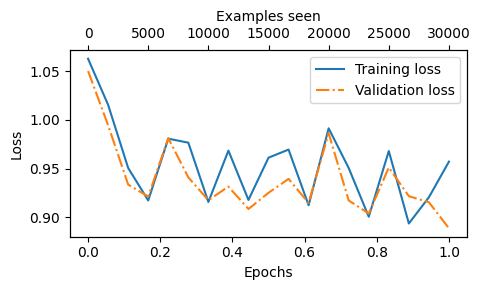

In [41]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

In [42]:
def classify_statement(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()

    # Prepare inputs to the model
    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[0]
    input_ids = input_ids[:min(max_length, supported_context_length)]

    # Pad sequences
    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0)  # Add batch dimension

    # Model inference
    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]  # Logits of last output token
    predicted_label = torch.argmax(logits, dim=-1).item()

    # Label mapping
    label_map = {
        0: "World",
        1: "Sports/film",
        2: "Business",
        3: "Sci/Tech"
    }

    return label_map.get(predicted_label, "Unknown")

In [43]:
text_1 = (
    "The brutalist grabs best film award at oscars"
)

print(classify_statement(
    text_1, gpt, tokenizer, device, max_length=train_dataset.max_length
))

World


In [44]:
text_2 = (
    "'Godfather of AI’ says AI is like a cute tiger cub—unless you know it won’t turn on you, you should worry"
)

print(classify_statement(
    text_2, gpt, tokenizer, device, max_length=train_dataset.max_length
))

World
